In [1]:
# importing the required Libraries 
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import learning_curve, StratifiedKFold
from scipy.sparse import hstack 

#import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# reading the cleaned data
data = pd.read_pickle('clean_data.pkl')
data

,combined_text,subject,label,text_length
0,united states budget fight looms republicans f...,6,1,442
1,united states military accept transgender recr...,6,1,364
2,senior united states republican senator let mr...,6,1,249
3,fbi russia probe helped australian diplomat ti...,6,1,227
4,trump wants postal service charge amazon shipm...,6,1,486
...,...,...,...,...
44893,mc pain john mccain furious iran treated sailo...,1,0,293
44894,justice yahoo mail privacy class action 4 lawy...,1,0,161
44895,sunni stan allied safe zone plan territorial n...,1,0,2074
44896,blow 700 million al jazeera america finally ca...,1,0,259


##### Splitting the Data

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('label', axis=1)
y = data['label']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# to know class distribution in the training and testing sets
print("Class distribution in y_train:\n",y_train.value_counts(normalize=True))
print("\nClass distribution in y_test:\n",y_test.value_counts(normalize=True))
# to know the dimensions of train and test sets
print(f"\nShapes:\nX_train={X_train.shape}, X_test={X_test.shape}")
print(f"y_train={y_train.shape}, y_test={y_test.shape}")

Class distribution in y_train:
 0    0.5254
1    0.4746
Name: label, dtype: float64

Class distribution in y_test:
 0    0.525344
1    0.474656
Name: label, dtype: float64

Shapes:
X_train=(35748, 3), X_test=(8937, 3)
y_train=(35748,), y_test=(8937,)


## Model Building and Evaluation

    We are considering unigrams, bigrams, and also trigrams for our model.
    Including them allows the model to capture both individual words and relationships between the words.

    We defined functions to build and evaluate the model which can be implemented for different classifiers.

In [5]:
# Function to get the models of different classifiers
def build_model(X_train, X_test, y_train, y_test, classifier, alpha=None, penalty=None, 
                ngram_ranges=None, max_features=None):
    vectorizers = []; X_test_vectorized_list = []
    for ngram_range, max_feature in zip(ngram_ranges, max_features):
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_feature)
        X_train_vectorized = vectorizer.fit_transform(X_train['combined_text'])
        vectorizers.append(vectorizer)
        X_test_vectorized_list.append(vectorizer.transform(X_test['combined_text']))
    # Combine the vectorized data
    X_train_vectorized = hstack([vectorizer.transform(X_train['combined_text']) for vectorizer in vectorizers])
    X_test_vectorized = hstack(X_test_vectorized_list)
    
    # Train the model based on the specified classifier
    if classifier == MultinomialNB:
        # Laplace smoothing (alpha parameter)
        model = classifier(alpha=alpha)
    elif classifier == LogisticRegression:
        # Logistic Regression with L1 or L2 regularization
        model = classifier(penalty=penalty, solver='saga', max_iter=1000, random_state=42)
    elif classifier == LogisticRegressionCV:
        # Logistic Regression with cross-validated hyperparameter search
        model = classifier(Cs=[0.001, 0.01, 0.1, 1, 10], penalty=penalty, solver='saga', max_iter=1000, cv=5)
    else:
        model = classifier()

    model.fit(X_train_vectorized, y_train)
    return model, vectorizers, X_test_vectorized, X_train_vectorized

In [6]:
# Function to evaluate the models
def evaluate_model(model, X_train_vectorized, X_test_vectorized, y_train, y_test):
    # Predictions on training set
    y_train_pred = model.predict(X_train_vectorized)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_matrix = confusion_matrix(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    
    # Predictions on testing set
    y_test_pred = model.predict(X_test_vectorized)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_matrix = confusion_matrix(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    return train_acc, train_matrix, train_report, train_mse, test_acc, test_matrix, test_report, test_mse

## Naïve Bayes - Multinomial
    MultinomialNB is widely used for text classification tasks, and it works well with the term frequency features typically used in natural language processing.

    To get the best max_features for unigrams, bigrams and trigrams.

In [7]:
def best_max_features(X_train, X_test, y_train, y_test, ngram_ranges, max_features_list):
    best_max_features = {}
    for ngram_range, max_features_values in zip(ngram_ranges, max_features_list):
        best_accuracy = 0; best_max_feature = None
        for max_feature in max_features_values:   # using the build_model function with MultinomialNB()
            model, _, X_test_vectorized, X_train_vectorized = build_model(
                X_train, X_test, y_train, y_test, MultinomialNB, alpha=2.0,
                ngram_ranges=[ngram_range], max_features=[max_feature])
            y_pred = model.predict(X_test_vectorized)
            accuracy = accuracy_score(y_test, y_pred)
            print(f'Accuracy for ngram_range={ngram_range}, max_features={max_feature}: {accuracy}')
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_max_feature = max_feature
        print(f"\nBest max_features for ngram_range={ngram_range}: {best_max_feature}\n")
        best_max_features[ngram_range] = best_max_feature
    return best_max_features

# Calling the function
ngram_ranges = [(1, 1), (2, 2), (3, 3)]
max_features_list = [[300, 500, 800], [800, 500, 300], [1500, 500, 800]]
best_max_features = best_max_features(X_train, X_test, y_train, y_test, ngram_ranges, max_features_list)

Accuracy for ngram_range=(1, 1), max_features=300: 0.9272686583864832
Accuracy for ngram_range=(1, 1), max_features=500: 0.9289470739621797
Accuracy for ngram_range=(1, 1), max_features=800: 0.9274924471299094

Best max_features for ngram_range=(1, 1): 500

Accuracy for ngram_range=(2, 2), max_features=800: 0.9468501734362762
Accuracy for ngram_range=(2, 2), max_features=500: 0.9399127223900637
Accuracy for ngram_range=(2, 2), max_features=300: 0.9309611726530156

Best max_features for ngram_range=(2, 2): 800

Accuracy for ngram_range=(3, 3), max_features=1500: 0.8968333892805191
Accuracy for ngram_range=(3, 3), max_features=500: 0.8440192458319347
Accuracy for ngram_range=(3, 3), max_features=800: 0.8725523106187759

Best max_features for ngram_range=(3, 3): 1500



In [8]:
# Fitting the MultinomialNB classifier

nb_model, nb_vectorizers, X_test_vectorized, X_train_vectorized = build_model(
    X_train, X_test, y_train, y_test, MultinomialNB,
    alpha=2.0, ngram_ranges=((1, 1), (2, 2), (3, 3)), max_features=(500, 800, 1500))

Training Accuracy: 0.9629070157771064

Training MSE: 0.03709298422289359

Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     18782
           1       0.95      0.98      0.96     16966

    accuracy                           0.96     35748
   macro avg       0.96      0.96      0.96     35748
weighted avg       0.96      0.96      0.96     35748



Testing Accuracy: 0.9634105404498153

Testing MSE: 0.036589459550184625

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4695
           1       0.95      0.98      0.96      4242

    accuracy                           0.96      8937
   macro avg       0.96      0.96      0.96      8937
weighted avg       0.96      0.96      0.96      8937



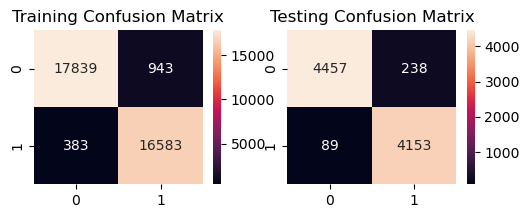

In [9]:
# Evaluating the Naive Bayes model
train_acc,train_matrix,train_report,train_mse, test_acc,test_matrix,test_report,test_mse = evaluate_model(
    nb_model, X_train_vectorized, X_test_vectorized, y_train, y_test)

# Print the results
print("Training Accuracy:", train_acc)
print("\nTraining MSE:", train_mse)
print("\nTraining Classification Report:")
print(train_report)
print("\n\nTesting Accuracy:", test_acc)
print("\nTesting MSE:", test_mse)
print("\nTesting Classification Report:")
print(test_report)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
sns.heatmap(train_matrix, annot=True, fmt="d",xticklabels=nb_model.classes_,yticklabels=nb_model.classes_)
plt.title("Training Confusion Matrix")
plt.subplot(1, 2, 2)
sns.heatmap(test_matrix, annot=True, fmt="d",xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Testing Confusion Matrix")
plt.show()

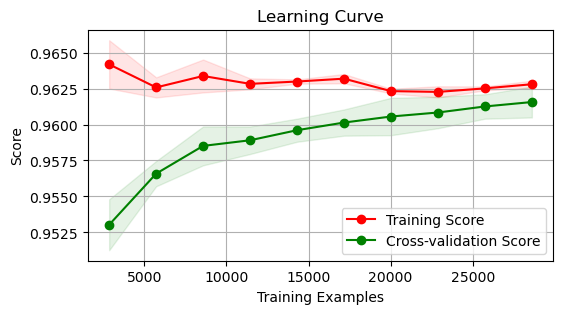

In [10]:
# Learning curve to know about the performance of the model
def plot_learning_curve(estimator,X, y,cv=None,train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(6, 3))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.legend(loc="best")
    plt.show()
    
plot_learning_curve(nb_model, X_train_vectorized, y_train, cv=5)

##### K - Fold Cross Validation

In [11]:
# Combine the train and test data
X_combined = pd.concat([X_train, X_test], ignore_index=True)
y_combined = pd.concat([y_train, y_test], ignore_index=True)
# Function for K-Fold Cross Validation
def kfold_cross_validation(model, X, y, ngram_ranges, max_features, num_folds=5, random_state=42):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    train_accuracies = []; test_accuracies = []
    for train_index, test_index in kf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        # Build the model with the current fold data
        nb_model, _, X_test_vectorized, X_train_vectorized = build_model(
            X_train_fold, X_test_fold, y_train_fold, y_test_fold,
            MultinomialNB, alpha=2.0, ngram_ranges=ngram_ranges, max_features=max_features)
        # Evaluate the model
        train_acc, _, _, _, test_acc, _, _, _ = evaluate_model(
            nb_model, X_train_vectorized, X_test_vectorized, y_train_fold, y_test_fold)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
    return train_accuracies, test_accuracies

train_accuracies, test_accuracies = kfold_cross_validation(
    nb_model, X_combined, y_combined, ((1, 1), (2, 2), (3, 3)), (500, 800, 1500))
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Testing Accuracy: {average_test_accuracy}')

Average Training Accuracy: 0.9632650777665883
Average Testing Accuracy: 0.9618216403714893


So, we can conclude that the MultinomialNB classifier model performs well on both the train and test data. It is neither overfitting nor underfitting.

## Logistic Regression
    As it is commonly used algorithm for binary classification tasks, and it can be a good choice for text classification problems like distinguishing between real and fake news.

In [12]:
# to get the best max_features for the unigrams, bigrams and trigrams
def best_max_features(X_train, X_test, y_train, y_test, ngram_ranges, max_features_list):
    best_max_features = {}
    for ngram_range, max_features_values in zip(ngram_ranges, max_features_list):
        best_accuracy = 0; best_max_feature = None
        for max_feature in max_features_values:  # using build_model function - LogisticRegression
            model, _, X_test_vectorized, X_train_vectorized = build_model(
                X_train, X_test, y_train, y_test, LogisticRegression, penalty='l2',
                ngram_ranges=[ngram_range], max_features=[max_feature])
            y_pred = model.predict(X_test_vectorized)
            accuracy = accuracy_score(y_test, y_pred)
            print(f'Accuracy for ngram_range={ngram_range}, max_features={max_feature}: {accuracy}')
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_max_feature = max_feature
        print(f"\nBest max_features for ngram_range={ngram_range}: {best_max_feature}\n")
        best_max_features[ngram_range] = best_max_feature
    return best_max_features

# Calling the function
ngram_ranges = [(1, 1), (2, 2), (3, 3)]
max_features_list = [[600, 300, 50], [200, 500, 300], [200, 500, 800]]
best_max_features = best_max_features(X_train, X_test, y_train, y_test, ngram_ranges, max_features_list)

Accuracy for ngram_range=(1, 1), max_features=600: 0.9841109992167394
Accuracy for ngram_range=(1, 1), max_features=300: 0.9815374286673381
Accuracy for ngram_range=(1, 1), max_features=50: 0.981425534295625

Best max_features for ngram_range=(1, 1): 600

Accuracy for ngram_range=(2, 2), max_features=200: 0.9376748349558017
Accuracy for ngram_range=(2, 2), max_features=500: 0.9632986460781022
Accuracy for ngram_range=(2, 2), max_features=300: 0.9497594271008168

Best max_features for ngram_range=(2, 2): 500

Accuracy for ngram_range=(3, 3), max_features=200: 0.8205214277721831
Accuracy for ngram_range=(3, 3), max_features=500: 0.8613628734474655
Accuracy for ngram_range=(3, 3), max_features=800: 0.8914624594382903

Best max_features for ngram_range=(3, 3): 800



In [13]:
# Fitting the Logistic Regression with 'L2' regularization 
lr_model, lr_vectorizers, X_test_vectorized, X_train_vectorized = build_model(
    X_train, X_test, y_train, y_test, LogisticRegression,
    penalty='l2', ngram_ranges=((1, 1), (2, 2), (3, 3)), max_features=(300, 500, 800))

Training Accuracy: 0.9942374398567752

Training MSE: 0.005762560143224796

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18782
           1       0.99      1.00      0.99     16966

    accuracy                           0.99     35748
   macro avg       0.99      0.99      0.99     35748
weighted avg       0.99      0.99      0.99     35748



Testing Accuracy: 0.9909365558912386

Testing MSE: 0.00906344410876133

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4695
           1       0.99      0.99      0.99      4242

    accuracy                           0.99      8937
   macro avg       0.99      0.99      0.99      8937
weighted avg       0.99      0.99      0.99      8937



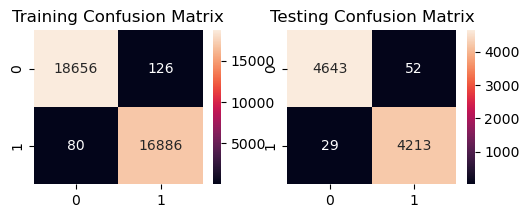

In [14]:
# Evaluating the Logistic Regression model
train_acc,train_matrix,train_report,train_mse, test_acc,test_matrix,test_report,test_mse = evaluate_model(
    lr_model, X_train_vectorized, X_test_vectorized, y_train, y_test)

# Print the results
print("Training Accuracy:", train_acc)
print("\nTraining MSE:", train_mse)
print("\nTraining Classification Report:")
print(train_report)
print("\n\nTesting Accuracy:", test_acc)
print("\nTesting MSE:", test_mse)
print("\nTesting Classification Report:")
print(test_report)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 2))
plt.subplot(1, 2, 1)
sns.heatmap(train_matrix, annot=True, fmt="d",xticklabels=lr_model.classes_,yticklabels=lr_model.classes_)
plt.title("Training Confusion Matrix")
plt.subplot(1, 2, 2)
sns.heatmap(test_matrix, annot=True, fmt="d",xticklabels=lr_model.classes_,yticklabels=lr_model.classes_)
plt.title("Testing Confusion Matrix")
plt.show()

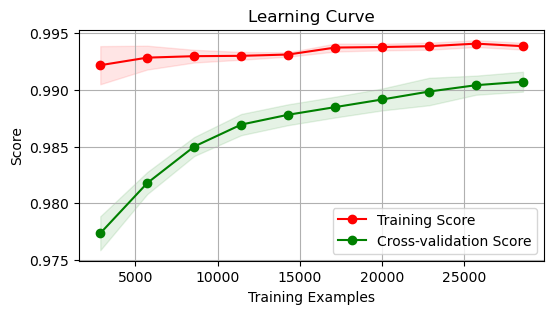

In [15]:
# plotting the learning curve Logistic Regression model
plot_learning_curve(lr_model, X_train_vectorized, y_train, cv=5)

##### K - Fold Cross Validation

In [16]:
# Combine the train and test data
X_combined = pd.concat([X_train, X_test], ignore_index=True)
y_combined = pd.concat([y_train, y_test], ignore_index=True)
# Function for K-Fold Cross Validation
def kfold_cross_validation(classifier, X, y, ngram_ranges, max_features, num_folds=5, random_state=42):
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    train_accuracies = []; test_accuracies = []
    for train_index, test_index in kf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        # Build and train a new model with the current fold data
        lr_model, _, X_test_vectorized, X_train_vectorized = build_model(
            X_train_fold, X_test_fold, y_train_fold, y_test_fold,
            classifier, penalty='l2', ngram_ranges=ngram_ranges, max_features=max_features)
        # Evaluate the model
        train_acc, _, _, _, test_acc, _, _, _ = evaluate_model(
            lr_model, X_train_vectorized, X_test_vectorized, y_train_fold, y_test_fold)
        # Store the results for this fold
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
    return train_accuracies, test_accuracies

train_accuracies, test_accuracies = kfold_cross_validation(
    LogisticRegression, X_combined, y_combined, [(1, 1), (2, 2), (3, 3)], 
    (300, 500, 800), num_folds=5, random_state=42)
average_train_accuracy = np.mean(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Testing Accuracy: {average_test_accuracy}')

Average Training Accuracy: 0.9941087613293051
Average Testing Accuracy: 0.9910260713886092


We can conclude that the Logistic Regression model also performs well on both the train and test sets.

In [18]:
from scipy.sparse import hstack
import pandas as pd  # Assuming 'pd' is imported for DataFrame operations

# Function to predict the class (real or fake) for new data
def predict_article_class(model, vectorizers, new_data):
    # Vectorize the new data using the same vectorizers
    vectorized_list = [vectorizer.transform(new_data['combined_text']) for vectorizer in vectorizers]
    new_data_vectorized = hstack(vectorized_list)
    # Predict the class
    predictions = model.predict(new_data_vectorized)
    return predictions

# Taking a sample of 10 articles from the test data
new_data_sample = X_test.sample(10)  # Assuming 'X_test' contains the new data
predictions = predict_article_class(nb_model, nb_vectorizers, new_data_sample)
# Combine the actual labels with the predicted labels
results = pd.DataFrame({
    'Article': new_data_sample['combined_text'],
    'Actual': y_test.loc[new_data_sample.index],  # Assuming 'y_test' is the actual labels
    'Predicted': predictions})
# Map 0 to 'fake' and 1 to 'real'
results['Actual'] = results['Actual'].map({0: 'Fake', 1: 'Real'})
results['Predicted'] = results['Predicted'].map({0: 'Fake', 1: 'Real'})
# Display the results in a table
results


,Article,Actual,Predicted
27721,marco rubio slams gop obstructing obama surpri...,Fake,Fake
22898,warren trump brutal commencement speech beauti...,Fake,Fake
37583,rob schneider nails russia conspiracy theorist...,Fake,Real
11110,pentagon chief preview fiscal 2017 budget feb ...,Real,Real
4308,tillers faces tough talks moscow amid increase...,Real,Real
15482,indonesian court recognizes native religions l...,Real,Real
791,open sesame lobbyists cheer warmer welcome tru...,Real,Real
29283,republicans twitter hilarious gop movies hash ...,Fake,Fake
25559,watch president obama tells whiny trump shut c...,Fake,Fake
21190,4 suspends staff uk migrant center says invest...,Real,Real


### Conclusion
    We decided to finalize the MultinomialNB classifier model for the classification of real and fake news analysis.

In [17]:
import pickle
   
with open('model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)
    
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(nb_vectorizers, file)    